In [235]:
%matplotlib inline
import pandas as pd

In [236]:
df = pd.read_csv('merged_dataset.csv')
df.columns

Index(['user_title', 'user_clevel', 'user_indus', 'user_disc', 'user_country',
       'user_region', 'user_premium', 'user_numb_work_experiences',
       'user_years_experience', 'user_years_experience_current',
       'user_edu_degree', 'user_edu_fieldofstudies', 'user_wtcj', 'item_title',
       'item_clevel', 'item_indus', 'item_disc', 'item_country', 'item_region',
       'item_is_payed', 'item_employment', 'item_tags', 'item_created_at',
       'interaction_type', 'interaction_created_at'],
      dtype='object')

In [58]:
def premium_boost(x):
    return 2 if (x['user_premium']) else 1

def clicked(x):
    return x['interaction_type'] == 1

def bookmarked(x):
    return x['interaction_type'] == 2

def replied(x):
    return x['interaction_type'] == 3

def recruiter_interest(x):
    return x['interaction_type'] == 5

def deleted(x):
    return x['interaction_type'] == 4

def user_success(x):
    return premium_boost(x) * (1 if clicked(x) else 0 + 5 if (bookmarked(x) or replied(x)) else 0 + 20 if recruiter_interest(x) else 0 - 10 if deleted else 0)

def item_success(x):
    return 5 if x["item_is_payed"] else 0

def score(x):
    return item_success(x) + user_success(x)

In [59]:
scores = df.apply(score, axis=1)

1.027483464177536
45
-20


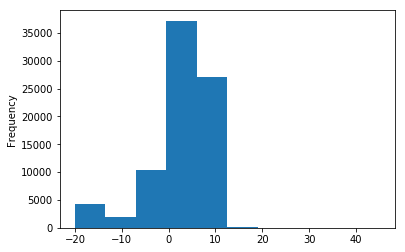

In [61]:
print(scores.mean())
print(scores.max())
print(scores.min())
scores.plot.hist()

In [237]:
df['user_country'] = df['user_country'].astype('category').cat.rename_categories([0,1,2,3])
df['item_country'] = df['item_country'].astype('category').cat.rename_categories([0,1,2,3])

In [313]:
columns = np.setdiff1d(df.columns.values, ['user_title', 'item_title', 'user_edu_fieldofstudies', 'item_tags', 'nhot_user_title', 'nhot_item_title', 'nhot_user_edu_fieldofstudies', 'nhot_item_tags', 'interaction_type', 'item_created_at', 'interaction_created_at'])
columns

array(['item_clevel', 'item_country', 'item_disc', 'item_employment',
       'item_indus', 'item_is_payed', 'item_region', 'user_clevel',
       'user_country', 'user_disc', 'user_edu_degree', 'user_indus',
       'user_numb_work_experiences', 'user_premium', 'user_region',
       'user_wtcj', 'user_years_experience',
       'user_years_experience_current'], dtype=object)

In [314]:
def n_hot_encode(df, column):
    
    # get unique elements from df[column] and put them into a set
    _set = set()

    for _list in df[column]:
        for _elem in _list:
            _set.add(_elem)

    # for each row, compute it's encoded vector indicating with a 
    # 1 that it contains that element from the set and a 0 that it doesn't
    _vectors = []
    
    for i in df.index:
        _vectors.append([1 if _elem in df[column][i] else 0 for _elem in _set])

    return _vectors

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def full_encoding(row):
    regular_columns = [row[col] for col in columns]
    nhot_columns = row['nhot_user_title'] + row['nhot_item_title'] + row['nhot_user_edu_fieldofstudies'] + row['nhot_item_tags']
    #print("regular: {}".format(regular_columns))
    #print("nhot: {}".format(nhot_columns))
    return regular_columns + nhot_columns

In [240]:
df['nhot_user_title'] = n_hot_encode(df, 'user_title')
df['nhot_item_title'] = n_hot_encode(df, 'item_title')
df['nhot_item_tags'] = n_hot_encode(df, 'item_tags')
df['nhot_user_edu_fieldofstudies'] = n_hot_encode(df, 'user_edu_fieldofstudies')

In [315]:
encoded_df = df.apply(full_encoding, axis=1)

In [318]:
data = np.zeros(shape=(len(encoded_df), len(encoded_df[0])))

# fill array with data taken from the df
for i, row in enumerate(encoded_df):
    data[i] = np.asarray(row)

In [363]:
target = df['interaction_type'].values

In [364]:
# save array to be used for training
print(data.shape)
print(data[0])

save_x_file = open('data.npy', 'wb')
np.save(save_x_file, data)

save_y_file = open('target.npy', 'wb')
np.save(save_y_file, target)

(5982813, 73)
[ 1.  2. 10.  1.  1.  0.  1.  0.  2.  0.  0. 20.  3.  0.  1.  1.  7.  5.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.]


In [2]:
# load array for training
import numpy as np

save_x_file = open('data.npy', 'rb')
data = np.load(save_x_file)

save_y_file = open('target.npy', 'rb')
target = np.load(save_y_file)

In [3]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split

/Users/piero/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [331]:
# remove rows with nan values
# NOT NECESSARY BECAUSE WE'RE NOT USING THE TIMESTAMPS WHICH CONTAINED nan VALUES

#print(encoded_df.shape)
#clean_df = encoded_df[np.isnan(data).any(axis=1)]
#print(clean_df.shape)

(5982813,)
(0,)


In [4]:
# resample the data to get more balanced classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

resampler = RandomOverSampler(random_state=0)
print(np.unique(target))

x_resampled, y_resampled = resampler.fit_sample(data, target)
print(sorted(Counter(y_resampled).items()))

[1 2 3 4 5]
[(1, 4931649), (2, 4931649), (3, 4931649), (4, 4931649), (5, 4931649)]


In [5]:
from keras.utils import to_categorical

y_resampled = to_categorical(y_resampled)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, 
    y_resampled, 
    test_size=0.2
)

In [7]:
input_dim = x_resampled.shape[1]
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=input_dim))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_resampled.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
# add a callback to stop if we start overfitting

from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=1, verbose=0, mode='auto')]

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=20, 
    batch_size=128,
    callbacks=callbacks)

Train on 19726596 samples, validate on 4931649 samples
Epoch 1/20
19726596/19726596 [==============================] - 762s 39us/step - loss: 1.0771 - acc: 0.5655 - val_loss: 0.9198 - val_acc: 0.6286
Epoch 2/20
19726596/19726596 [==============================] - 675s 34us/step - loss: 1.0141 - acc: 0.5901 - val_loss: 0.8986 - val_acc: 0.6333
Epoch 3/20
    9088/19726596 [..............................] - ETA: 1:57:38 - loss: 1.0093 - acc: 0.5938

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.legend()
plt.show()

In [ ]:
#sample = np.expand_dims(data[0], axis=0)  # predict one instance
print(model.predict(x_test[:2]))  # predict some instances

In [ ]:
arr = model.predict(x_test[1:2])[0]
print(arr.max(), np.argmax(arr), arr.min(), np.argmin(arr))

In [ ]:
predictions = model.predict(x_test)

In [ ]:
np.unique(predictions, axis=0).shape